# **Netflix Subscriptions Forecasting using Python**


## Project Scenario

Netflix, a popular streaming platform, forecasts subscription growth to optimize its resource planning to meet the growing demands of its subscribers efficiently. They use historical data on quarterly subscriptions, which includes the number of subscribers at different periods.

The company aims to use the forecasts to  plan, strategize, and make data-driven decisions. It enhances operational efficiency, financial planning, and content strategy, ultimately contributing to their success and growth in the highly competitive streaming industry.

## Project Objectives
Build a forecasting model to forecast the number of subscriptions for the upcoming quarters.

## Tasks to do
- Gather historical Netflix subscriptions growth data
- Preprocess and clean the data
- Explore and analyze time series patterns
- Choose a time series forecasting model (e.g., ARIMA, LSTM)
- Train the model using the training data
- Forecast future Netflix subscription counts



## Data Description:

This dataset is used to build a forecasting model that accurately predicts the future quarterly subscriptions for Netflix. The dataset contains subscription counts of Netflix at the start of each quarter from 2013 to 2023. Below are the features in the dataset:
- Time Period: Quarterly time period
- Subscribers: Number of subscribers at the end of each quarter

**Data Source:** https://statso.io/forecasting-subscriptions-case-study/

**Preferences:** 
https://thecleverprogrammer.com/2023/08/07netflix-subscriptions-forecasting-using-python/

## 1. Import Libraries and Data

In [7]:
#Import Libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px
import plotly.io as pio
pio.templates.default = "plotly_white"
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

In [8]:
#Read the dataset
data = pd.read_csv(r"C:\Users\HP\Downloads\Python\Netflix-Subscriptions.csv")
data.head()

,Time Period,Subscribers
0,01/04/2013,34240000
1,01/07/2013,35640000
2,01/10/2013,38010000
3,01/01/2014,41430000
4,01/04/2014,46130000


## 2. Data Preprocessing


In [9]:
#Retrieve dataset summary: 
data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 42 entries, 0 to 41
Data columns (total 2 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   Time Period  42 non-null     object
 1   Subscribers  42 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 804.0+ bytes


- The dataset contains 42 entries, there are no null values in the data.
- Dtype of "Time Period" is object, so we need to convert the Time Period column into a datetime format

In [10]:
# Fix the data type of Time Period as datetime
data["Time Period"] = pd.to_datetime(data["Time Period"], format="%d/%m/%Y")
data.head()

,Time Period,Subscribers
0,2013-04-01,34240000
1,2013-07-01,35640000
2,2013-10-01,38010000
3,2014-01-01,41430000
4,2014-04-01,46130000


## 3. Analyze time series patterns


In [11]:
# Visualize quarterly subscription of Netflix:
fig = go.Figure()
fig.add_trace(
    go.Scatter(
        x=data["Time Period"], y=data["Subscribers"], mode="lines", name="Subscribers"
    )
)
fig.update_layout(
    title="Netflix Quarterly Subscriptions",
    xaxis_title="Date",
    yaxis_title="Netflix Subscriptions",
)
fig.show()

c:\Users\HP\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



As can be seen from the above graph, we can see that there is **an increasing trend** in Netflix subscribers from 2013 to present and the time series is not affected by seasonal factors. So we can use a forecasting technique like **ARIMA** in this dataset.

In [14]:
# Calculate the quarterly growth rate
data["Quarterly Growth Rate"] = data["Subscribers"].pct_change() * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data["Bar Color 1"] = data["Quarterly Growth Rate"].apply(
    lambda x: "green" if x > 0 else "red"
)

# Plot the quarterly growth rate using bar graphs
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=data["Time Period"],
        y=data["Quarterly Growth Rate"],
        marker_color=data["Bar Color 1"],
        name="Quarterly Growth Rate",
    )
)
fig.update_layout(
    title="Netflix Quarterly Subscriptions Growth Rate",
    xaxis_title="Time Period",
    yaxis_title="Quarterly Growth Rate (%)",
)
fig.show()

c:\Users\HP\anaconda3\Lib\site-packages\_plotly_utils\basevalidators.py:106: FutureWarning:

The behavior of DatetimeProperties.to_pydatetime is deprecated, in a future version this will return a Series containing python datetime objects instead of an ndarray. To retain the old behavior, call `np.array` on the result



In [ ]:
Q1_2022 = data['Quarterly Growth Rate'][36]*data['Subscribers'][35]
Q2_2022 = data['Quarterly Growth Rate'][37]*data['Subscribers'][36]

In April 2022, the company revealed its first subscriber decline since 2013, with a loss of 200,000 (-0.0902%) subscribers in the first quarter of 2022 (Q 12022). During the Q2 2022 earnings, Netflix reported nearly a 1 million subscriber loss (-0.4376%) between April and July. 

In [17]:
# Calculate the yearly growth rate
data["Year"] = data["Time Period"].dt.year
yearly_growth = data.groupby("Year")["Subscribers"].pct_change().fillna(0) * 100

# Create a new column for bar color (green for positive growth, red for negative growth)
data["Bar Color 2"] = yearly_growth.apply(lambda x: "green" if x > 0 else "red")

# Plot the yearly subscriber growth rate using bar graphs
fig = go.Figure()
fig.add_trace(
    go.Bar(
        x=data["Year"],
        y=yearly_growth,
        marker_color=data["Bar Color 2"],
        name="Yearly Growth Rate",
    )
)
fig.update_layout(
    title="Netflix Yearly Subscriber Growth Rate",
    xaxis_title="Year",
    yaxis_title="Yearly Growth Rate (%)",
)
fig.show()

## 4. Using ARIMA for Forecasting


**ARIMA** stands for **AutoRegressive Integrated Moving Average**
- ARIMA models use past values of the time series and past errors to predict future values.
- ARIMA models have three parameters: p, d, and q.
    - p is the number of lagged observations or the order of the autoregressive term.
    - d is the number of times the data is differenced or the degree of differencing if the time series is non-stationary.
    - q is the size of the moving average window or the order of the moving average term.

In [27]:
#Converting the data into a time series format:
time_series = data.set_index('Time Period')['Subscribers']

As can be seen from "Netflix Quarterly Subscriptions" graph that the data we are using is non-stationary, we need to use methods of differencing

1. ADF :  -4.523088428253381
2. P-Value :  0.00017858926729786263
3. Num Of Lags :  0
4. Num Of Observations Used For ADF Regression and Critical Values Calculation : 40
5. Critical Values :
	 1% :  -3.6055648906249997
	 5% :  -2.937069375
	 10% :  -2.606985625


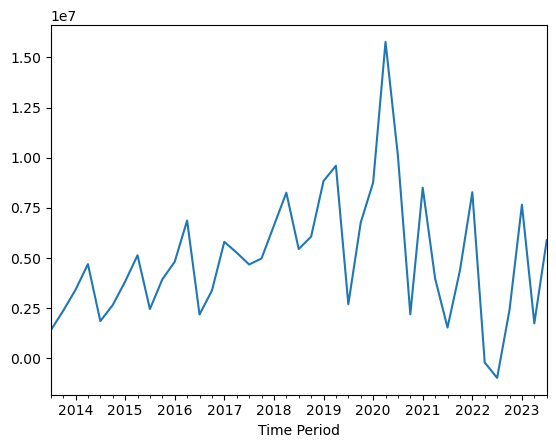

In [34]:
#Calculate the differenced time series from the original time_series, removed any NaN values 
differenced_series = time_series.diff(1).dropna()

#Test if the differenced_series(1) is stationary
from statsmodels.tsa.stattools import adfuller
dftest = adfuller(differenced_series, autolag = 'AIC')
print("1. ADF : ",dftest[0])
print("2. P-Value : ", dftest[1])
print("3. Num Of Lags : ", dftest[2])
print("4. Num Of Observations Used For ADF Regression and Critical Values Calculation :", dftest[3])
print("5. Critical Values :")
for key, val in dftest[4].items():
    print("\t",key, ": ", val)
differenced_series.plot();

We can see that the p-value is near about zero and very less than 0.05; now, our time series is stationary. So after these all processes, we can move to the modelling side.

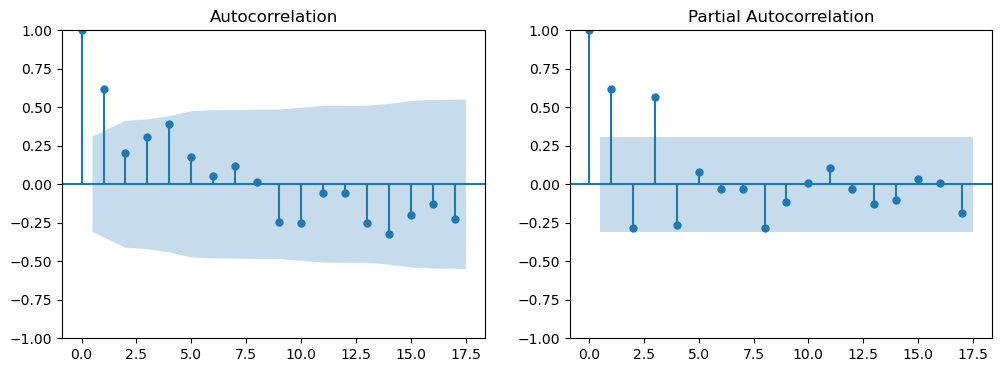

In [30]:
# Plot ACF and PACF of differenced time series
fig, axes = plt.subplots(1, 2, figsize=(12, 4))
plot_acf(differenced_series, ax=axes[0])
plot_pacf(differenced_series, ax=axes[1])
**plt.show()

Based on the plots, we find that **p=1** and **q=1**. The ACF plot cuts off at lag 1, indicating q=1, and the PACF plot also cuts off at lag 1, indicating p=1. As there is a linear trend in the subscription growth rate, we can set the value of **d=1** to remove the linear trend, making the time series stationary.

## 5. Train the model using the training data

In [35]:
#Train the model
p, d, q = 1, 1, 1
model = ARIMA(time_series, order=(p, d, q))
results = model.fit()
print(results.summary())

                               SARIMAX Results                                
Dep. Variable:            Subscribers   No. Observations:                   42
Model:                 ARIMA(1, 1, 1)   Log Likelihood                -672.993
Date:                Thu, 07 Dec 2023   AIC                           1351.986
Time:                        09:16:55   BIC                           1357.127
Sample:                    04-01-2013   HQIC                          1353.858
                         - 07-01-2023                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.9997      0.012     80.763      0.000       0.975       1.024
ma.L1         -0.9908      0.221     -4.476      0.000      -1.425      -0.557
sigma2      1.187e+13   1.57e-14   7.57e+26      0.0

c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.

c:\Users\HP\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning:

No frequency information was provided, so inferred frequency QS-OCT will be used.



## 6. Forecast future Netflix subscription

In [36]:
#Make predictions using the trained model
future_steps = 5
predictions = results.predict(
    len(time_series), len(time_series) + future_steps - 1, dynamic=True
)
predictions = predictions.astype(int)

In [38]:
# Create a DataFrame with the original data and predictions
forecast = pd.DataFrame({'Original': time_series, 'Predictions': predictions})

# Plot the original data and predictions
fig = go.Figure()

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Predictions'],
                         mode='lines', name='Predictions'))

fig.add_trace(go.Scatter(x=forecast.index, y=forecast['Original'],
                         mode='lines', name='Original Data'))

fig.update_layout(title='Netflix Quarterly Subscription Predictions',
                  xaxis_title='Time Period',
                  yaxis_title='Subscribers',
                  legend=dict(x=0.1, y=0.9),
                  showlegend=True)

fig.show()

## Summary
- The Netflix Quarterly Subscription is predicted to increase in the next 5 quarters 
- Using techniques like time series forecasting, Netflix can estimate the expected number of new subscribers in a given time period and better understand the growth potential of their business. It enhances operational efficiency, financial planning, and content strategy, ultimately contributing to their success and growth in the highly competitive streaming industry